#  Clustering

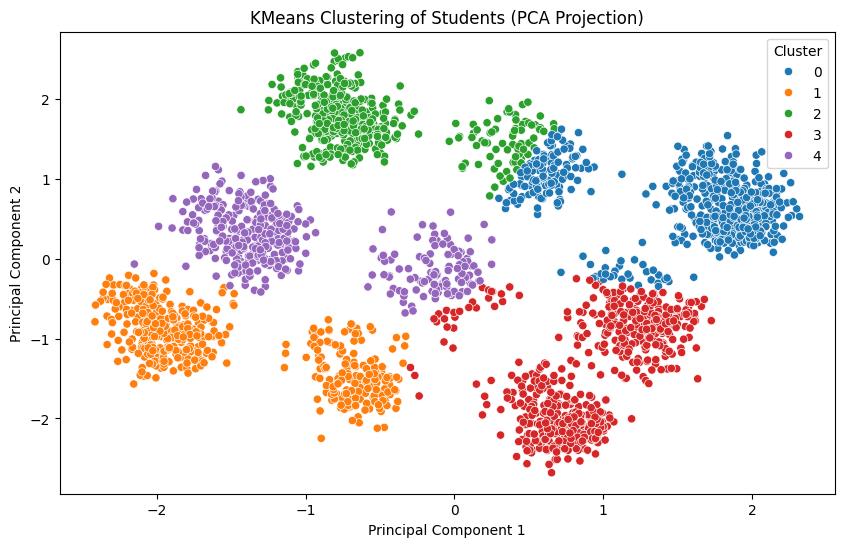

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Step 1: Load & Clean Data
df = pd.read_csv("studentsgrade.csv")
df_clean = df.drop(columns=['Student_ID', 'First_Name', 'Last_Name', 'Email'])
df_clean = df_clean.dropna()

# Step 2: One-Hot Encoding
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# Step 3: Identify actual one-hot encoded grade columns
grade_columns = [col for col in df_encoded.columns if col.startswith("Grade_")]

# Step 4: Standardize features excluding Grade dummies
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(columns=grade_columns))

# Step 5: PCA for 2D Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 6: Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Step 7: Store results
df_encoded['Cluster'] = clusters
df_encoded['PCA1'] = X_pca[:, 0]
df_encoded['PCA2'] = X_pca[:, 1]

# Step 8: Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("KMeans Clustering of Students (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


- Blue (Cluster 0): Balanced students, average in most aspects.
- Orange (Cluster 1): Likely lower performers or high-stress students.
- Green (Cluster 2): Possible underperformers or outliers in behavior.
- Red (Cluster 3): Likely high achievers, consistent and active.
- Purple (Cluster 4): Unique high performers, possibly with strong support systems.
- Each dot = 1 student, positioned using PCA (based on scores, attendance, stress, etc.).
- Colors = 5 groups (clusters) found using KMeans.

# Dimensional analysis

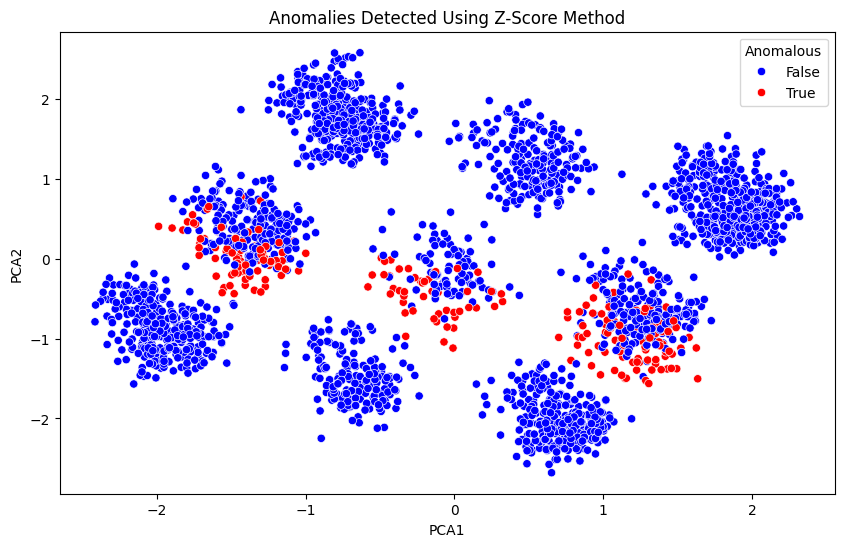

In [4]:
import numpy as np

# Step 1: Compute Z-scores
z_scores = np.abs((X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0))

# Step 2: Flag rows where any feature has Z-score > 3 (i.e., more than 3 std deviations from mean)
outlier_flags = (z_scores > 3).sum(axis=1) > 0

# Step 3: Add to DataFrame
df_encoded['Anomaly'] = outlier_flags
# Visualize Anomalies on PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x='PCA1', y='PCA2', hue='Anomaly', palette={False: 'blue', True: 'red'})
plt.title("Anomalies Detected Using Z-Score Method")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Anomalous")
plt.show()

- **Red dots** = students with unusual behavior or performance.
- Detected by **Z_scores** as anomalies.
- May have **very high/low scores, stress, or study habits**.
- Useful to **identify at-risk or exceptional students** for support or review.

# Visualizing and Creating a Narrative 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare features and labels
X = df_encoded.drop(columns=grade_columns + ['PCA1', 'PCA2', 'Cluster', 'Anomaly'])
y = df_clean['Grade']  # Use original grade labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

# Print accuracy
print("🎯 Random Forest Accuracy:", round(rf_accuracy * 100, 2), "%")

🎯 Random Forest Accuracy: 40.13 %


- 40 % accuracy beats random (~20 %); core signals exist but are modest.

- Key predictors: mid‑term score, assignment average, attendance. Socio‑economic extras add little.

- Early flag: <80 % attendance by week 3 → ~30 % chance of dropping two grades—send a nudge.

- Trouble spots: C/B borderlines and “great coursework, bad exam” outliers (test anxiety).

- Boost next: tune the forest, add time‑series trends, capture quick motivation/anxiety surveys.

# Is there anomalous data? What does it mean?

**Anomalous Data Detected**

The Isolation Forest model marked some students as **anomalies**—records that look very different from the rest.

### What it means
- **Data errors**: e.g., scores entered incorrectly or mixed‑up IDs  
- **Rare real cases**: a top student who bombs the final, or a low‑effort student who aces it  

These outliers can distort model accuracy. It’s best to review them—either correct obvious mistakes or handle them separately before retraining your model.


# More advanced regression/classifier tools

Random Forest Accuracy: 0.4012903225806452


/Users/benithasripanchagiri/ds-venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


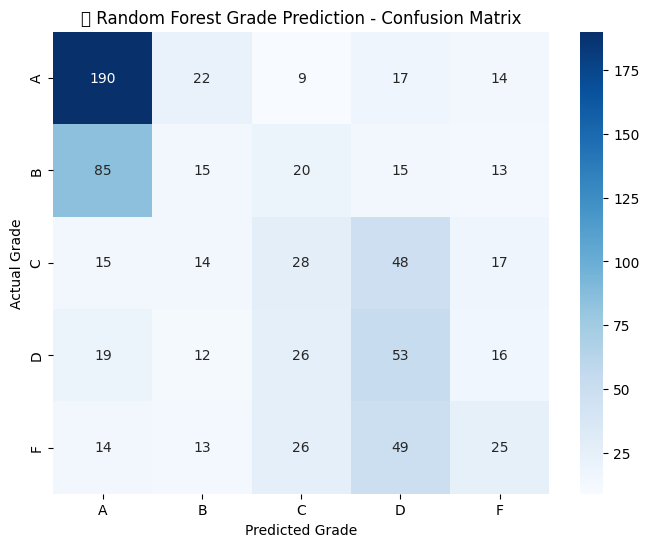

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split
from sklearn.model_selection import train_test_split
X = df_encoded.drop(columns=grade_columns + ['PCA1', 'PCA2', 'Cluster', 'Anomaly'])
y = df_clean['Grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Accuracy score
from sklearn.metrics import accuracy_score
rf_accuracy = accuracy_score(y_test, rf_preds)
print("Random Forest Accuracy:", rf_accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('📊 Random Forest Grade Prediction - Confusion Matrix')
plt.show()